# Convert audio into Mel-spectrogram

In [ ]:
import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

image_size = (512, 512)

# Initialize an image counter
image_counter = 1

audio_folder = "Audio_DatasetEmotion" # Path to your dataset folders
output_folder = "Audio_DatasetEmotion_ImagesMelSpectrograms"  # Path to save the balanced dataset

# Folder to save all "angry" mel-spectrogram images
angry_output_folder = os.path.join(output_folder, "angry")
os.makedirs(angry_output_folder, exist_ok=True)

# Function to generate and save mel-spectrogram as image (for training)
def save_mel_spectrogram_for_training(audio_path, output_path, image_size):
    y, sr = librosa.load(audio_path, sr=None)  # Load audio file with original sample rate
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)  # Compute mel-spectrogram
    S_dB = librosa.power_to_db(S, ref=np.max)  # Convert to decibels (normalization)

    plt.figure(figsize=(image_size[0] / 100, image_size[1] / 100))  # Adjust figure size for consistency
    librosa.display.specshow(S_dB, sr=sr, x_axis=None, y_axis=None, cmap='viridis')  # No axis labels
    plt.axis('off')  # Remove axes
    plt.tight_layout(pad=0)  # Remove padding
    
    # Save image as a PNG
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
    plt.close()

# Iterate over each emotion folder in the input directory
for emotion_folder in os.listdir(audio_folder):
    emotion_folder_path = os.path.join(audio_folder, emotion_folder)
    
    # Skip non-folder files
    if not os.path.isdir(emotion_folder_path):
        continue
    
    # Iterate over all audio files in the emotion folder
    for file_name in os.listdir(emotion_folder_path):
        audio_file_path = os.path.join(emotion_folder_path, file_name)
        
        # Check if the file is an audio file
        if file_name.endswith('.wav'):
            try:
                # Only process "angry" emotion
                if emotion_folder == "angry":
                    # Define the output image name and path in the 'angry' folder
                    new_image_name = f"ImageAudio_{image_counter}_angry.png"
                    image_output_path = os.path.join(angry_output_folder, new_image_name)
                    
                    # Save mel-spectrogram image for training
                    save_mel_spectrogram_for_training(audio_file_path, image_output_path, image_size)
                    print(f"Saved: {new_image_name}")
                    
                    # Increment the image counter
                    image_counter += 1

            except Exception as e:
                print(f"Error processing {audio_file_path}: {str(e)}")
                continue

print("All 'angry' mel-spectrogram images have been extracted and saved for model training.")


# CNN-BiLSTM Model for Mel-Spectrograms

In [ ]:
import os
import random
import shutil
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, Reshape, Bidirectional, LSTM
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
img_height, img_width = 256, 256
batch_size = 16
num_classes = 5
learning_rate = 0.0001
input_shape = (256, 256, 3)

In [ ]:
model = Sequential()

# First Conv Block
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3), padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Second Conv Block
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# Third Conv Block
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# Fourth Conv Block (for deeper features)
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

# Fifth Conv Block (optional - only if needed for even deeper feature extraction)
model.add(Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

# Reshape for LSTM input
model.add(Reshape((64, 512)))  # Reshape to (timesteps, features)

# BiLSTM layer
model.add(Bidirectional(LSTM(128, return_sequences=False, dropout=0.3, recurrent_dropout=0.3)))

# Fully Connected Layers
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Output Layer
model.add(Dense(5, activation='softmax'))

In [ ]:
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 16, 16, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 64, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │       656,384 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,329,797 (8.89 MB)

 Trainable params: 2,327,045 (8.88 MB)

 Non-trainable params: 2,752 (10.75 KB)

In [ ]:
checkpoint = ModelCheckpoint(
    'model111.keras',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

In [ ]:
# Early stopping to prevent overfitting
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=9,  # Stop training if no improvement in 7 epochs
    restore_best_weights=True,
    verbose=1
)

In [ ]:
# Learning rate scheduler
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,  # Reduce the learning rate if no improvement in 3 epochs
    min_lr=1e-6,
    verbose=1
)

In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    'train',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 49000 images belonging to 5 classes.


In [ ]:
validation_generator = val_datagen.flow_from_directory(
    'val',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 10500 images belonging to 5 classes.


In [ ]:
# Train the model with the callbacks
history = model.fit(
    train_generator,
    epochs=100,  # Start with more epochs; early stopping will stop if no improvement
    validation_data=validation_generator,
    callbacks=[checkpoint, reduce_lr, early_stop]
)

c:\Users\hp\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
3063/3063 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2223 - loss: 3.4695
Epoch 1: val_loss improved from inf to 2.84540, saving model to model111.keras
3063/3063 ━━━━━━━━━━━━━━━━━━━━ 3710s 1s/step - accuracy: 0.2223 - loss: 3.4694 - val_accuracy: 0.2407 - val_loss: 2.8454 - learning_rate: 1.0000e-04
Epoch 2/100
3063/3063 ━━━━━━━━━━━━━━━━━━━━ 0s 977ms/step - accuracy: 0.2453 - loss: 2.9039
Epoch 2: val_loss improved from 2.84540 to 2.74255, saving model to model111.keras
3063/3063 ━━━━━━━━━━━━━━━━━━━━ 3132s 1s/step - accuracy: 0.2453 - loss: 2.9039 - val_accuracy: 0.2346 - val_loss: 2.7425 - learning_rate: 1.0000e-04
Epoch 3/100
3063/3063 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2735 - loss: 2.6646
Epoch 3: val_loss improved from 2.74255 to 2.58064, saving model to model111.keras
3063/3063 ━━━━━━━━━━━━━━━━━━━━ 3296s 1s/step - accuracy: 0.2735 - loss: 2.6646 - val_accuracy: 0.2870 - val_loss: 2.5806 - learning_rate: 1.0000e-04
Epoch 4/100
3063/3063 ━━━━━━━━━━━━━━━━━━━

In [ ]:
model.save('best-CNNBi.h5')

In [ ]:
model.save_weights('best-CNNBi.weights.h5')

In [ ]:
test_generator = val_datagen.flow_from_directory(
    'test',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,  # Shuffle should be False for evaluation
)

Found 10500 images belonging to 5 classes.


In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

657/657 ━━━━━━━━━━━━━━━━━━━━ 174s 265ms/step - accuracy: 0.5479 - loss: 1.2553
Test Accuracy: 51.61%


In [ ]:
print(test_accuracy)

0.5160952210426331


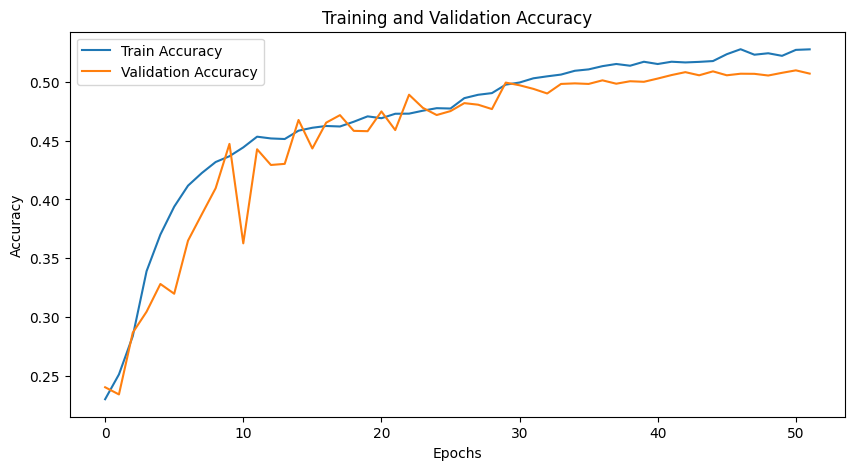

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

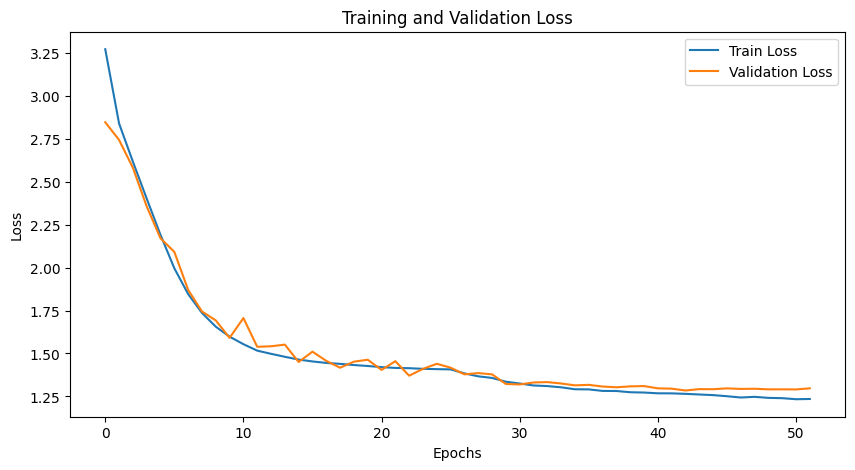

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

657/657 ━━━━━━━━━━━━━━━━━━━━ 166s 251ms/step


In [ ]:
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys()))

Classification Report:
              precision    recall  f1-score   support

       angry       0.63      0.60      0.62      2100
        calm       0.42      0.52      0.47      2100
     disgust       0.53      0.54      0.54      2100
       happy       0.57      0.39      0.46      2100
         sad       0.47      0.53      0.50      2100

    accuracy                           0.52     10500
   macro avg       0.53      0.52      0.52     10500
weighted avg       0.53      0.52      0.52     10500



In [ ]:
conf_matrix = confusion_matrix(y_true, y_pred_classes)

In [ ]:
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

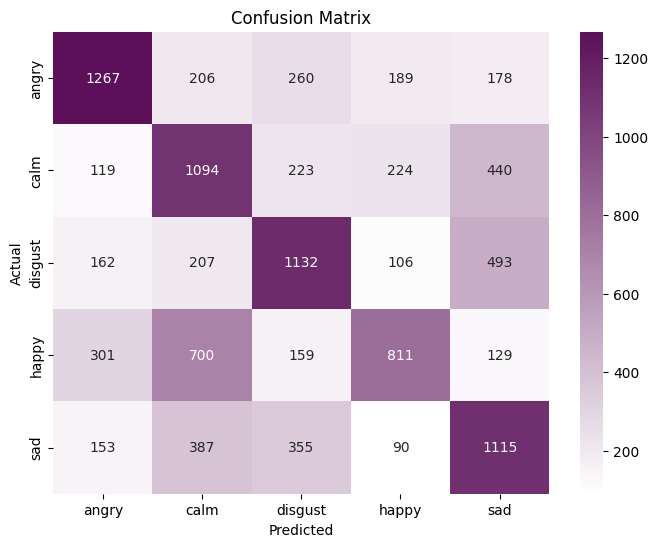

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

# Define the custom color map using a specific purple tone
purple_color = '#5B1059'  # Replace this with the exact hex code if needed
custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_purple", ["#ffffff", purple_color])

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=custom_cmap,  # Use the custom color map
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

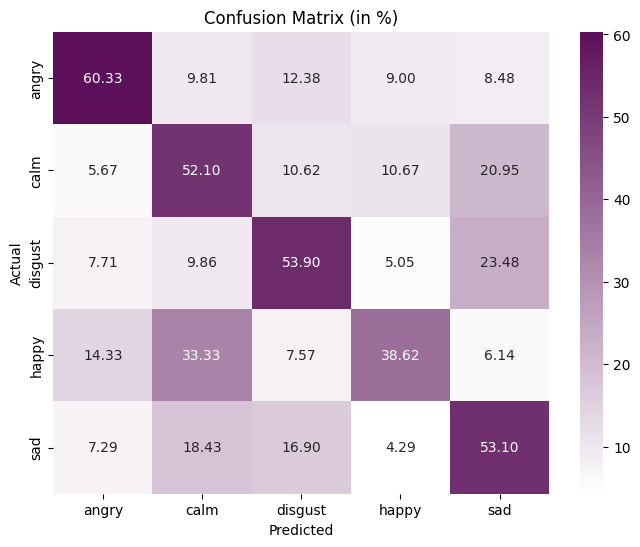

In [ ]:
purple_color = '#5B1059'  # Replace this with the exact hex code if needed
custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_purple", ["#ffffff", purple_color])

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2f", cmap=custom_cmap, 
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (in %)')
plt.show()